Cargando dataset Spambase desde: https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data
✅ Dataset cargado. Shape X: (4601, 57), Shape Y: (4601,)

--- 1. Gráfica de Dispersión (PCA 2D) ---


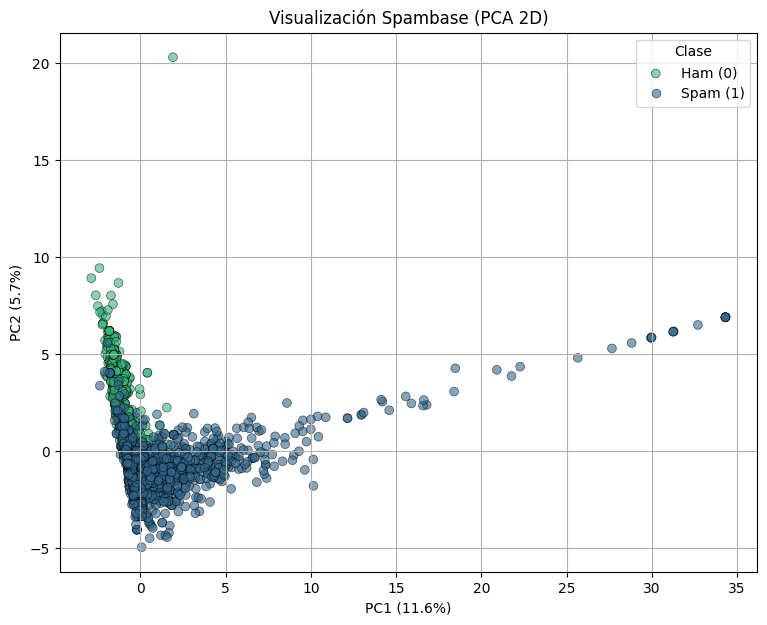


Entrenando Gradient Boosting en las 57 características (Modelo Principal)...

  Métricas de Gradient Boosting (57D)
Accuracy: 0.9464
F1 Score: 0.9438
Precision: 0.9447
Recall: 0.9429


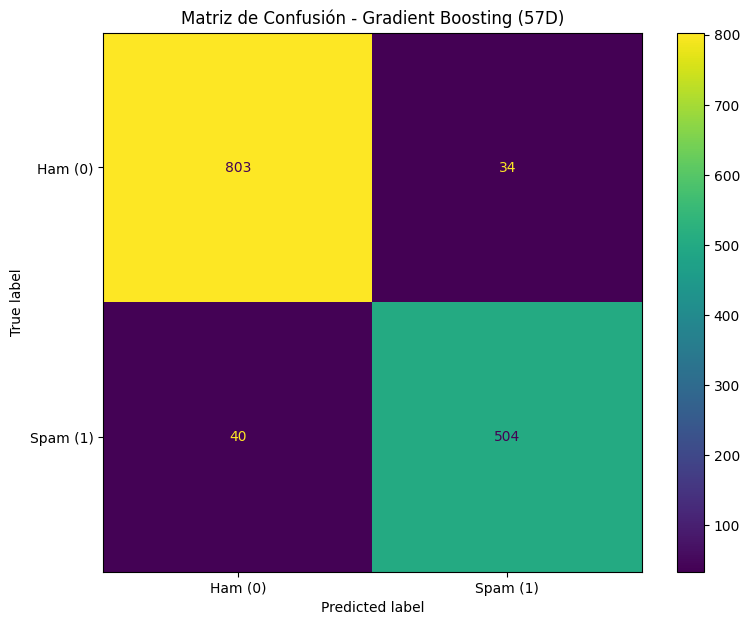


--- 2. Gráfica de Regiones de Decisión (PCA 2D) ---


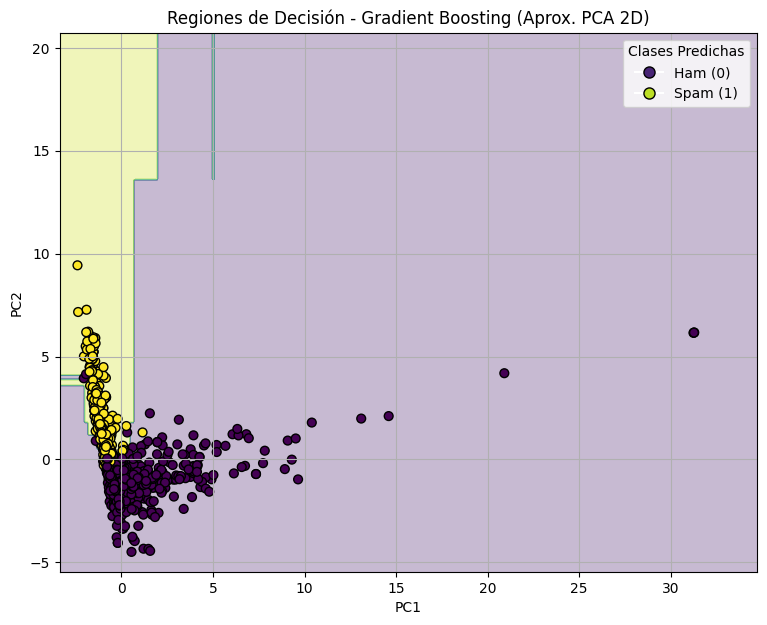

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# ===Usamos GradientBoostingClassifier ===
from sklearn.ensemble import GradientBoostingClassifier
# ======================================================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# =============================
# 1. Cargar dataset Spambase (UCI)
# =============================
URL_DATASET = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
print(f"Cargando dataset Spambase desde: {URL_DATASET}")

try:
    df_full = pd.read_csv(URL_DATASET, header=None)
    # 57 features + 1 target
    feature_cols = [f"f_{i}" for i in range(1, 58)]
    df_full.columns = feature_cols + ["is_spam"]

    X = df_full.iloc[:, :-1].values
    Y = df_full.iloc[:, -1].values
    class_names = ["Ham (0)", "Spam (1)"]
    print(f"✅ Dataset cargado. Shape X: {X.shape}, Shape Y: {Y.shape}")
except Exception as e:
    print(f"❌ ERROR CRÍTICO al cargar el dataset: {e}")
    exit()

# =============================
# 2. Preprocesamiento (Escalado)
# =============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =============================
# 3. Reducción a 2D para VISUALIZACIÓN (PCA)
# =============================
pca = PCA(n_components=2)
X_reduced_viz = pca.fit_transform(X_scaled)

df_viz = pd.DataFrame(X_reduced_viz, columns=["PC1", "PC2"])
df_viz["target"] = Y

# =============================
# 4. Gráfica 1: Visualización del Dataset en 2D
# =============================
print("\n--- 1. Gráfica de Dispersión (PCA 2D) ---")
plt.figure(figsize=(9, 7))
sns.scatterplot(x=df_viz["PC1"], y=df_viz["PC2"], hue=df_viz["target"],
                palette="viridis", edgecolor="k", alpha=0.6, s=40)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Visualización Spambase (PCA 2D)")
plt.legend(title="Clase", labels=class_names)
plt.grid(True)
plt.show()

# ==============================================================
# 5. Entrenamiento del Modelo PRINCIPAL (Gradient Boosting en 57D)
# ==============================================================
# Dividir el dataset escalado COMPLETO para el entrenamiento principal
X_train_full, X_test_full, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.3, random_state=42, stratify=Y
)

# === CLASIFICADOR REQUERIDO: GRADIENT BOOSTING ===
model_full = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
print("\nEntrenando Gradient Boosting en las 57 características (Modelo Principal)...")
model_full.fit(X_train_full, Y_train)
Y_pred_full = model_full.predict(X_test_full)

# =============================
# 6. Métricas y Matriz de Confusión (Modelo Principal 57D)
# =============================
acc = accuracy_score(Y_test, Y_pred_full)
f1 = f1_score(Y_test, Y_pred_full, average="macro")
prec = precision_score(Y_test, Y_pred_full, average="macro")
rec = recall_score(Y_test, Y_pred_full, average="macro")

print("\n==============================================")
print("  Métricas de Gradient Boosting (57D)")
print("==============================================")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")

# --- Matriz de Confusión (Modelo Principal) ---
cm = confusion_matrix(Y_test, Y_pred_full, labels=model_full.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(9, 7))
disp.plot(cmap="viridis", values_format="d", ax=plt.gca())
plt.title("Matriz de Confusión - Gradient Boosting (57D)")
plt.show()

# ==============================================================
# 7. Entrenamiento del Modelo 2D para GRÁFICA DE DECISIÓN
# ==============================================================
# Usamos la versión reducida (X_reduced_viz) solo para generar la gráfica de decisión
X_train_viz, X_test_viz, Y_train_viz, Y_test_viz = train_test_split(
    X_reduced_viz, Y, test_size=0.3, random_state=42, stratify=Y
)

# Entrenar un nuevo Gradient Boosting en solo 2D
model_viz = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model_viz.fit(X_train_viz, Y_train_viz)

# =============================
# 8. Gráfica 2: Regiones de Decisión (Modelo 2D)
# =============================
print("\n--- 2. Gráfica de Regiones de Decisión (PCA 2D) ---")
x_min, x_max = X_reduced_viz[:,0].min() - 0.5, X_reduced_viz[:,0].max() + 0.5
y_min, y_max = X_reduced_viz[:,1].min() - 0.5, X_reduced_viz[:,1].max() + 0.5
# Usamos un paso más fino (0.1) para una gráfica de regiones más suave
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = model_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(9, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="viridis")

# Graficamos los puntos de prueba (modelo 2D) coloreados por la PREDICCIÓN
Y_pred_viz = model_viz.predict(X_test_viz)
scatter = plt.scatter(X_test_viz[:,0], X_test_viz[:,1], c=Y_pred_viz,
                      cmap="viridis", edgecolor="k", s=40)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Regiones de Decisión - Gradient Boosting (Aprox. PCA 2D)")

# Leyenda manual
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=class_names[0], markerfacecolor=plt.cm.viridis(0.1), markersize=8, markeredgecolor='k'),
    plt.Line2D([0], [0], marker='o', color='w', label=class_names[1], markerfacecolor=plt.cm.viridis(0.9), markersize=8, markeredgecolor='k')
]
plt.legend(handles=legend_elements, title="Clases Predichas")
plt.grid(True)
plt.show()